In [1]:
import ast
from typing import Annotated, TypedDict
from uuid import uuid4

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import AIMessage, HumanMessage, ToolCall
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

In [3]:
import os

search = DuckDuckGoSearchRun()

In [4]:
tools = [search, calculator]

In [5]:
model = ChatOllama(
    base_url="http://localhost:11434", model="qwq:32b", temperature=0.1
).bind_tools(tools)

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

In [7]:
# ! important here!!!
def first_model(state: State) -> State:
    query = state["messages"][-1].content # -1 means the last message
    search_tool_call = ToolCall(
        name="duckduckgo_search",
        args={"query": query},
        id=uuid4().hex
    )
    return {"messages": AIMessage(content="", tool_calls=[search_tool_call])}

In [8]:
builder = StateGraph(State) # a graph based on State

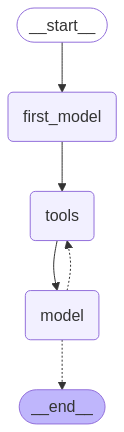

In [9]:
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges(
    "model", tools_condition
)  # Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
builder.add_edge("tools", "model")

graph = builder.compile()
graph

In [10]:
os.environ["HTTP_PROXY"] = "http://localhost:10086"
os.environ["HTTPS_PROXY"] = "http://localhost:10086"

In [11]:
input = {
    "messages": [
        HumanMessage(
            """How old was the 30th president of the United States when he died?"""
        )
    ]
}
for c in graph.stream(input):
    print(c)

{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='b622dd34-2543-46c9-b1e2-19db282d016a', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'How old was the 30th president of the United States when he died?'}, 'id': 'b184cf571e2246f4a70e753c74b397ce', 'type': 'tool_call'}])}}
{'tools': {'messages': [ToolMessage(content='John Calvin Coolidge Jr. [1] (/ ˈ k uː l ɪ dʒ / KOOL-ij; July 4, 1872 - January 5, 1933) was the 30th president of the United States, serving from 1923 to 1929.A Republican lawyer from Massachusetts, he previously served as the 29th vice president from 1921 to 1923 under President Warren G. Harding, and as the 48th governor of Massachusetts from 1919 to 1921. The White House, official residence of the president of the United States, in July 2008. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College